In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import copy

In [51]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size,batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,batch_first=True)
        self.linear = nn.Linear(self.hidden_size,self.output_size)
 
    def forward(self,inputseq):
        #LSTM的另外两个输入是 h0 和 c0，可以理解成网络的初始化参数，用随机数生成即可
        h_0 = torch.randn(self.num_directions*self.num_layers,self.batch_size,self.hidden_size)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size)
        output,_ = self.lstm(inputseq,(h_0,c_0))
        pred = self.linear(output[:,-1,:])
        return pred

In [52]:
def read_data(filename):
    data = pd.read_csv(filename)
    data=data.iloc[:,:2]
    L = data.shape[0]
    print("data的尺寸为：{}".format(data.shape))
    return data,L

def process_data(data,N):
    XY=[]
    for i in range(len(data) - N):
        X = []
        Y = []
        for j in range(N):
            X.append(data.iloc[i+j, 1])
        Y.append(data.iloc[i + N, 1])
        X = torch.FloatTensor(X).view(-1,1)
        Y = torch.FloatTensor(Y)
        XY.append((X,Y))
    return XY
 
class MyDataset(Dataset):
    def __init__(self,data):
        self.data = data
 
    def __getitem__(self, item):
        return self.data[item]
 
    def __len__(self):
        return len(self.data)
 
def data_loader(data,N,batch_size,shuffle):
    seq = process_data(data, N)
    seq_set = MyDataset(seq)
    seq = DataLoader(dataset=seq_set,batch_size=batch_size,shuffle=shuffle,drop_last=True)
    return seq_set,seq


In [53]:
def get_parameters():
    para_dict = {
        "input_size":1,
        "output_size":1,
        "batch_size":5,
        "hidden_size":64,
        "num_layers":3,
        "seq_len":24,
        "modelpara_path":'md.pth',
        "loss_function":'mse',
        "optimizer":'Adam',
        "lr":0.0001,
        "epoch":20,
    }
    return para_dict

In [54]:
def train_proc(para_dict,train_data,val_data):
    input_size=para_dict["input_size"]
    hidden_size = para_dict["hidden_size"]
    num_layers = para_dict["num_layers"]
    output_size = para_dict["output_size"]
    batch_size = para_dict["batch_size"]
    lr = para_dict["lr"]
    epoch = para_dict["epoch"]
    model = LSTM(input_size,hidden_size,num_layers,output_size,batch_size)
    model
    #优化器保存当前的状态，并可以进行参数的更新
    if para_dict["optimizer"]=='Adam':
        optimizer = torch.optim.Adam(model.parameters(),lr)
    if para_dict["loss_function"]=='mse':
        loss_function = nn.MSELoss()
 
    best_model = None
    min_val_loss = float('inf')
    train_loss = []
    val_loss = []
 
    for i in tqdm(range(epoch)):
        train_loss_tmp = 0
        val_loss_tmp = 0
        # 训练
        model.train()
        for curdata in train_data:
            seq, label = curdata
            seq = seq
            label = label
            # 计算网络输出
            y_pred = model(seq)
            # 计算损失
            loss = loss_function(y_pred,label)
            train_loss_tmp += loss.item()
            # 计算梯度和反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # 验证
        model.eval()
        for (seq, label) in val_data:
            seq = seq
            label = label
            with torch.no_grad():
                y_pred = model(seq)
                loss = loss_function(y_pred,label)
                val_loss_tmp += loss.item()
        # 最优模型
        if val_loss_tmp<min_val_loss:
            min_val_loss = val_loss_tmp
            best_model = copy.deepcopy(model)
        #损失保存
        train_loss_tmp /= len(train_data)
        val_loss_tmp /= len(val_data)
        train_loss.append(train_loss_tmp)
        val_loss.append(val_loss_tmp)
        print("epoch={:03d}:  train_loss = {:05f},val_loss = {:05f}".format(i,train_loss_tmp,val_loss_tmp))
    # 绘制损失曲线
    plt.figure()
    plt.plot(range(epoch),train_loss,'r')
    plt.plot(range(epoch), val_loss, 'b')
    plt.legend(['train','val'])
    plt.show()
    #保存模型
    state = {'models':best_model.state_dict()}
    torch.save(state,para_dict["modelpara_path"])

In [55]:
def test_proc(para_dict,test_data,min_val,max_val):
    input_size=para_dict["input_size"]
    hidden_size = para_dict["hidden_size"]
    num_layers = para_dict["num_layers"]
    output_size = para_dict["output_size"]
    batch_size = para_dict["batch_size"]
    lr = para_dict["lr"]
    epoch = para_dict["epoch"]
    path = para_dict["modelpara_path"]
    model = LSTM(input_size,hidden_size,num_layers,output_size,batch_size)
    model
    print("loading models ......")
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
 
    pred = []#list
    labels = []
    for curdata in test_data:
        seq, label = curdata
        seq = seq
        label = label
        with torch.no_grad():
            y_pred = model(seq)
        for j in range(len(y_pred)):
            y = y_pred[j].item()*(max_val-min_val)+min_val
            lb = label[j].item()*(max_val-min_val)+min_val
            pred.append(y)
            labels.append(lb)
    errs = np.array(pred)-np.array(labels)
    mape = abs(errs/np.array(labels)).sum()/len(errs)
    print('预测结果：MAPE={:.3f}%'.format(mape*100))
    # 绘制预测对比曲线
    plt.figure()
    plt.plot(pred,'r')
    plt.plot(labels, 'b')
    plt.legend(['pred','labels'])
    plt.show()
 
    plt.figure()
    plt.plot(errs)
    plt.show()

data的尺寸为：(1258, 2)
训练集的大小为(1133, 2)
验证集的大小为(62, 2)
测试集的大小为(61, 2)
训练数据导入完毕！
验证数据导入完毕！
测试数据导入完毕！
开始训练


  5%|▌         | 1/20 [00:00<00:18,  1.00it/s]

epoch=000:  train_loss = 0.113244,val_loss = 0.019872


 10%|█         | 2/20 [00:02<00:18,  1.01s/it]

epoch=001:  train_loss = 0.005935,val_loss = 0.002461


 15%|█▌        | 3/20 [00:02<00:16,  1.01it/s]

epoch=002:  train_loss = 0.003485,val_loss = 0.001140


 20%|██        | 4/20 [00:03<00:15,  1.02it/s]

epoch=003:  train_loss = 0.002629,val_loss = 0.002052


 25%|██▌       | 5/20 [00:04<00:14,  1.03it/s]

epoch=004:  train_loss = 0.002043,val_loss = 0.002569


 30%|███       | 6/20 [00:05<00:13,  1.02it/s]

epoch=005:  train_loss = 0.001843,val_loss = 0.002997


 35%|███▌      | 7/20 [00:06<00:12,  1.02it/s]

epoch=006:  train_loss = 0.001699,val_loss = 0.003722


 40%|████      | 8/20 [00:07<00:11,  1.03it/s]

epoch=007:  train_loss = 0.001580,val_loss = 0.002221


 45%|████▌     | 9/20 [00:08<00:10,  1.03it/s]

epoch=008:  train_loss = 0.001533,val_loss = 0.000765


 50%|█████     | 10/20 [00:09<00:09,  1.03it/s]

epoch=009:  train_loss = 0.001447,val_loss = 0.003348


 55%|█████▌    | 11/20 [00:10<00:08,  1.01it/s]

epoch=010:  train_loss = 0.001441,val_loss = 0.000547


 60%|██████    | 12/20 [00:11<00:07,  1.02it/s]

epoch=011:  train_loss = 0.001382,val_loss = 0.000393


 65%|██████▌   | 13/20 [00:12<00:06,  1.03it/s]

epoch=012:  train_loss = 0.001299,val_loss = 0.002068


 70%|███████   | 14/20 [00:13<00:05,  1.04it/s]

epoch=013:  train_loss = 0.001281,val_loss = 0.003083


 75%|███████▌  | 15/20 [00:14<00:04,  1.04it/s]

epoch=014:  train_loss = 0.001215,val_loss = 0.001593


 80%|████████  | 16/20 [00:15<00:03,  1.04it/s]

epoch=015:  train_loss = 0.001182,val_loss = 0.000519


 85%|████████▌ | 17/20 [00:16<00:02,  1.04it/s]

epoch=016:  train_loss = 0.001210,val_loss = 0.001023


 90%|█████████ | 18/20 [00:17<00:01,  1.04it/s]

epoch=017:  train_loss = 0.001194,val_loss = 0.000778


 95%|█████████▌| 19/20 [00:18<00:00,  1.04it/s]

epoch=018:  train_loss = 0.001198,val_loss = 0.000278


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]

epoch=019:  train_loss = 0.001155,val_loss = 0.000599


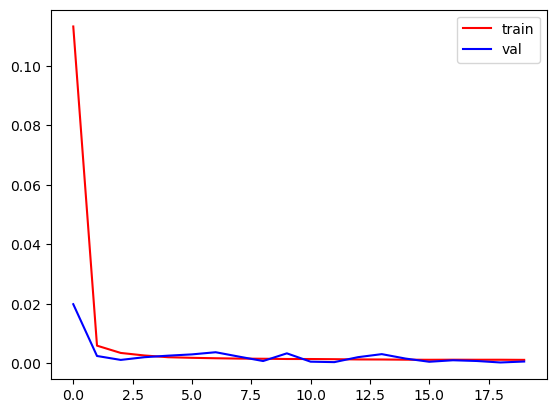

开始测试
loading models ......
预测结果：MAPE=1.537%


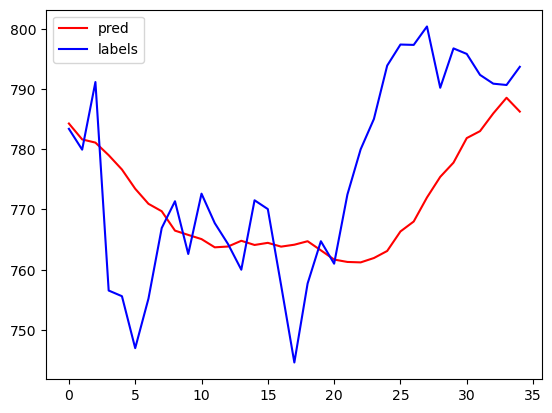

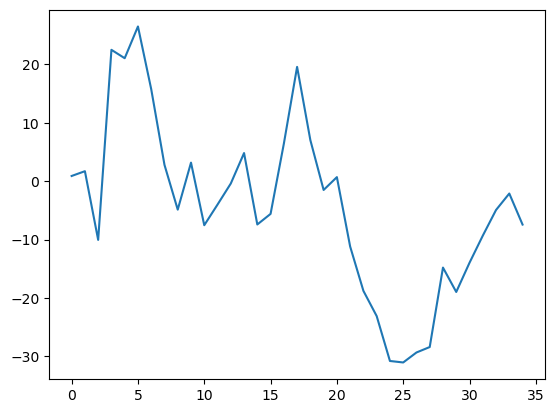

训练完毕！！！！


In [56]:
if __name__ == '__main__':
 
    filename = "data/Google_Stock_Price_Train.csv"
    data,L = read_data(filename)
    # 归一化
    min_val = min(data.iloc[:,1])
    max_val = max(data.iloc[:,1])
    data.iloc[:, 1] = (data.iloc[:,1]-min_val)/(max_val-min_val)
 
    train_pro = 0.9
    val_pro = 0.95
    test_pro = 1
    train = data.loc[:len(data)*train_pro,:]
    val = data.loc[len(data)*train_pro+1:len(data)*val_pro,:]
    test = data.loc[len(data)*val_pro+1:len(data)*test_pro,:]
    print("训练集的大小为{}".format(train.shape))
    print("验证集的大小为{}".format(val.shape))
    print("测试集的大小为{}".format(test.shape))
 
 
    para_dict = get_parameters()
    batch_size = para_dict["batch_size"]
    N = para_dict["seq_len"]
    train_data_set,train_data = data_loader(train,N,batch_size,True)
    print('训练数据导入完毕！')
    val_data_set,val_data = data_loader(val, N,batch_size,True)
    print('验证数据导入完毕！')
    test_data_set,test_data = data_loader(test, N,batch_size,False)
    print('测试数据导入完毕！')
 
    print("开始训练")
    train_proc(para_dict,train_data,val_data)
    print("开始测试")
    test_proc(para_dict, test_data,min_val,max_val)
    print('训练完毕！！！！')

[LSTM的多变量时间序列预测（北京PM2.5预测）](https://blog.csdn.net/qyk666/article/details/135773980)

In [27]:
from pandas import read_csv
from datetime import datetime
# 加载数据
def parse(x):
    return datetime.strptime(x,'%Y %m %d %H')
dataset=read_csv('data/raw.csv',parse_dates=[['year','month','day','hour']],index_col=0,date_parser=parse)
dataset.drop('No',axis=1,inplace=True)
# 手动更改列名
dataset.columns=['pollution','dew','temp','press','wnd_dir','wnd_spd','snow','rain']
dataset.index.name='data'
# 把所有NA值用0替换
dataset['pollution'].fillna(0,inplace=True)
dataset=dataset[24:]
# 输出前五行
print(dataset.head(5))
# 保存到文件中
dataset.to_csv('data/pollution.csv')


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21436\493765455.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset=read_csv('data/raw.csv',parse_dates=[['year','month','day','hour']],index_col=0,date_parser=parse)


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
data                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


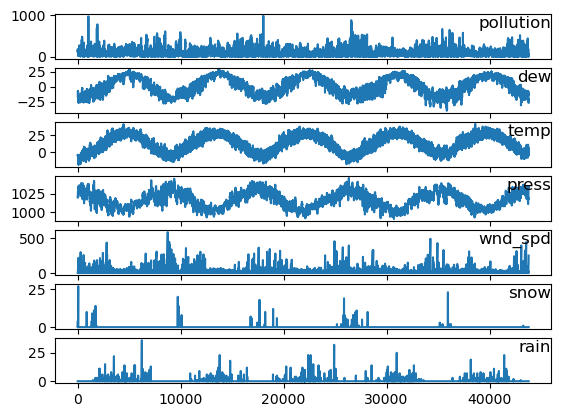

In [28]:
from pandas import read_csv
from matplotlib import pyplot
# 加载数据集
dataset=read_csv('data/pollution.csv',header=0,index_col=0)
values=dataset.values
# 指定要绘制的列
groups=[0,1,2,3,5,6,7]
i=1
# 绘制每一列
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups),1,i)
    pyplot.plot(values[:,group])
    pyplot.title(dataset.columns[group],y=0.5,loc='right')
    i+=1
pyplot.show()


In [29]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

In [30]:
# 将序列转换成监督学习问题

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# 加载数据集
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
values = dataset.values
# 整数编码方向
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# 确保所有数据是浮动的
values = values.astype('float32')
# 归一化特征
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 构建成监督学习问题
reframed = series_to_supervised(scaled, 1, 1)
# 丢弃我们不想预测的列
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [50]:
# 把数据分为训练集和测试集
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# 把数据分为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 把输入重塑成3D格式 [样例， 时间步, 特征]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm

class Config():
    data_path = 'data/pollution.csv'
    timestep = 20  # 时间步长，就是利用多少时间窗口
    batch_size = 32  # 批次大小
    feature_size = 8  # 每个步长对应的特征数量，这里只使用1维，每天的风速
    hidden_size = 256  # 隐层大小
    output_size = 1  # 由于是多输出任务，最终输出层大小为2，预测未来2天风速
    num_layers = 2  # lstm的层数
    epochs = 10 # 迭代轮数
    best_loss = 0 # 记录损失
    learning_rate = 0.0003 # 学习率
    model_name = 'lstm' # 模型名称
    save_path = './{}.pth'.format(model_name) # 最优模型保存路径

config = Config()

# 1.加载时间序列数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# 把数据分为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 把输入重塑成3D格式 [样例， 时间步, 特征]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
 
# 加载数据集
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
values = dataset.values
# 整数编码方向
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# 确保所有数据是浮动的
values = values.astype('float32')
# 归一化特征
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 构建成监督学习问题
reframed = series_to_supervised(scaled, 1, 1)
# 丢弃我们不想预测的列
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)


# 4.将数据转为tensor
x_train_tensor = torch.from_numpy(train_X).to(torch.float32)
y_train_tensor = torch.from_numpy(train_y).to(torch.float32)
x_test_tensor = torch.from_numpy(test_X).to(torch.float32)
y_test_tensor = torch.from_numpy(test_y).to(torch.float32)

# 5.形成训练数据集
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

# 6.将数据加载成迭代器
train_loader = torch.utils.data.DataLoader(train_data,
                                           config.batch_size,
                                           False)

test_loader = torch.utils.data.DataLoader(test_data,
                                          config.batch_size,
                                          False)

# 7.定义LSTM网络
class LSTM(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size  # 隐层大小
        self.num_layers = num_layers  # lstm层数
        # feature_size为特征维度，就是每个时间点对应的特征数量，这里为1
        self.lstm = nn.LSTM(feature_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        batch_size = x.shape[0] # 获取批次大小
        
        # 初始化隐层状态
        if hidden is None:
            h_0 = x.data.new(self.num_layers, batch_size, self.hidden_size).fill_(0).float()
            c_0 = x.data.new(self.num_layers, batch_size, self.hidden_size).fill_(0).float()
        else:
            h_0, c_0 = hidden
            
        # LSTM运算
        output, (h_0, c_0) = self.lstm(x, (h_0, c_0))
        
        # 全连接层
        output = self.fc(output)  # 形状为batch_size * timestep, 1
        
        # 我们只需要返回最后一个时间片的数据即可
        return output[:, -1, :]

model = LSTM(config.feature_size, config.hidden_size, config.num_layers, config.output_size)  # 定义LSTM网络
loss_function = nn.MSELoss()  # 定义损失函数
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)  # 定义优化器

# 8.模型训练
for epoch in range(config.epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader)  # 形成进度条
    for data in train_bar:
        x_train, y_train = data  # 解包迭代器中的X和Y
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = loss_function(y_train_pred, y_train)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 config.epochs,
                                                                 loss)

    # 模型验证
    model.eval()
    test_loss = 0
    with torch.no_grad():
        test_bar = tqdm(test_loader)
        for data in test_bar:
            x_test, y_test = data
            y_test_pred = model(x_test)
            test_loss = loss_function(y_test_pred, y_test)

    if test_loss < config.best_loss:
        config.best_loss = test_loss
        torch.save(model.state_dict(), "lstm.pth")

print('Finished Training')



In [ ]:
# 9.绘制结果
plot_size = 200
y_test_pred = model(x_test_tensor)
plt.figure(figsize=(12, 8))
plt.plot(scaler.inverse_transform(y_test_pred.detach().numpy()[: plot_size, 0].reshape(-1, 1)), "b")
plt.plot(scaler.inverse_transform(y_test_tensor.detach().numpy().reshape(-1, 1)[: plot_size]), "r")
plt.legend()
plt.show()

In [97]:
y_test_pred.detach().numpy()

array([[0.04384664],
       [0.04192504],
       [0.03655089],
       ...,
       [0.0282669 ],
       [0.02834638],
       [0.02699308]], dtype=float32)

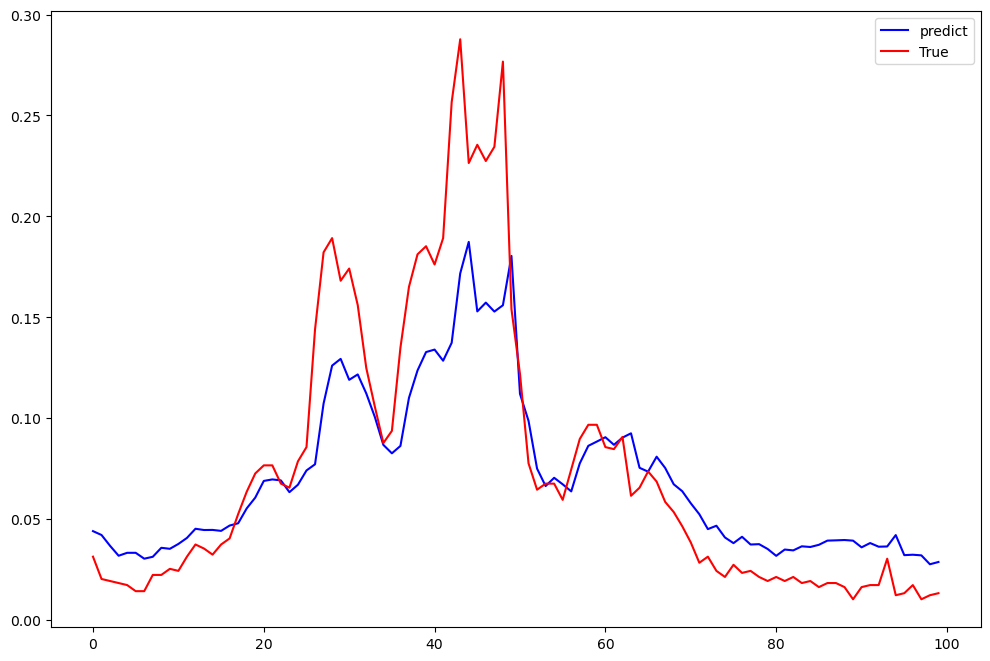

In [100]:
plot_size = 200
y_test_pred = model(x_test_tensor)
plt.figure(figsize=(12, 8))
plt.plot(y_test_pred.detach().numpy()[:100], "b",label="predict")
plt.plot(np.array(y_test_tensor)[:100], "r",label="True")
plt.legend()
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# 设计网络
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 拟合网络
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# 绘制历史数据
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# 做出预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# 反向转换预测值比例
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反向转换实际值比例
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# 计算RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
